In [87]:
import os
import pandas as pd
import sys
sys.path.insert(0, '/home/jupyter/')
from hourly_pollution_prediction.process_and_join.bbox import * 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#for image inpainting
from skimage import data
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint
import cv2 as cv
import xesmf as xe
import geopandas as gpd
import rioxarray
from rioxarray.merge import merge_arrays
from pathlib import Path

weather= xr.open_dataset("../../data/weather_data_samehr/weather_data_2024-01.nc", engine='netcdf4')

ca_shapefile = gpd.read_file("cancer_alley_shapefile/cancer_alley_polygon.shp")
weather = weather.rio.write_crs("EPSG:4326")  # assuming your data is in WGS84
weather=weather[['UGRD','VGRD']]
shapefile = gpd.read_file("louisiana.geojson")
# Clip to shape
weather=weather.rename({'lat':'latitude','lon':'longitude'})
Cancer_alley_weather = weather.rio.clip(ca_shapefile.geometry, shapefile.crs, drop=True)
mean_wind = Cancer_alley_weather.mean(dim=['time','latitude','longitude'], keep_attrs=True)
mean_wind

<xarray.Dataset> Size: 16B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    UGRD         float32 4B -0.8144
    VGRD         float32 4B -0.4722
Attributes: (12/18)
    date_range:               [1434585600000 1647907200000]
    description:              <p>The Real-Time Mesoscale Analysis (RTMA) is a...
    keywords:                 ['climate', 'cloud', 'geophysical', 'humidity',...
    period:                   0
    product_tags:             ['wind', 'temperature', 'humidity', 'geophysica...
    provider:                 NOAA/NWS
    ...                       ...
    type_name:                ImageCollection
    visualization_0_bands:    WIND
    visualization_0_max:      12.0
    visualization_0_min:      0.0
    visualization_0_name:     Wind Speed
    visualization_0_palette:  001137,01abab,e7eb05,620500

In [90]:
df = pd.read_csv("../../data/tempo_data/no2_tempo_files_df.csv")

timestamps_dt = pd.to_datetime(df['timestamp_ct'])
unique_months = timestamps_dt.dt.to_period('M').unique()
all_winds = pd.DataFrame()
# Compare to a Period object, not a string
# unique_months = [month for month in unique_months if month != pd.Period('2025-06', freq='M')]
for month in unique_months:
    month_str = str(month)
    weather= xr.open_dataset(f"../../data/weather_data_samehr/weather_data_{month_str}.nc", engine='netcdf4')

    ca_shapefile = gpd.read_file("cancer_alley_shapefile/cancer_alley_polygon.shp")
    weather = weather.rio.write_crs("EPSG:4326")  # assuming your data is in WGS84
    weather=weather[['UGRD','VGRD']]
    shapefile = gpd.read_file("louisiana.geojson")
    # Clip to shape
    weather=weather.rename({'lat':'latitude','lon':'longitude'})
    Cancer_alley_weather = weather.rio.clip(ca_shapefile.geometry, shapefile.crs, drop=True)
    mean_wind = Cancer_alley_weather.mean(dim=['time','latitude','longitude'], keep_attrs=True)
    # Extract scalar values from DataArrays
    ugrd = float(mean_wind['UGRD'].values)
    vgrd = float(mean_wind['VGRD'].values)

    # Build a one-row DataFrame manually
    mean_wind_df = pd.DataFrame([{
        'UGRD': ugrd,
        'VGRD': vgrd,
        'month': month_str
    }])    
    all_winds = pd.concat([all_winds, mean_wind_df], axis=0)

In [92]:
all_winds.to_csv('winds_by_month.csv')

In [96]:
# List of target months
southwest_months = ['2023-09','2023-10', '2023-11', '2023-12', '2024-01','2024-08','2024-09', '2024-10','2024-11', '2024-12', '2025-01', '2025-02']
northeast_months = ['2024-02', '2024-07', '2025-03', '2025-05']
# Container for results
months = southwest_months+northeast_months
monthly_means = []

for month in months:
    path = f"../../data/tempo_data/no2_monthly_files/tempo_no2_{month}.nc"
    tempo_ds = xr.open_dataset(path, engine='netcdf4')[['vertical_column_troposphere']]
    tempo_ds = tempo_ds.rio.write_crs("EPSG:4326")

    # Clip and compute full spatiotemporal means
    def region_mean(ds, geom):
        clipped = ds.rio.clip(geom.geometry, shapefile.crs, drop=True)
        data_array = clipped['vertical_column_troposphere']
        mean_value = data_array.mean(dim=['latitude', 'longitude', 'time'])
        return float(mean_value.values)
    
    cancer_alley_val = region_mean(tempo_ds, ca_shapefile)
    northeast_val    = region_mean(tempo_ds, ca_north)
    southwest_val    = region_mean(tempo_ds, ca_south)

    if month in southwest_months:
        direction = 'southwest'
    else:
        direction = 'northeast'
    monthly_means.append({
        'month': month,
        'cancer_alley': cancer_alley_val,
        'northeast': northeast_val,
        'southwest': southwest_val,
        'direction':direction
    })

# Convert to DataFrame
monthly_means_df = pd.DataFrame(monthly_means)


In [107]:
monthly_means_df = pd.DataFrame(monthly_means)


In [108]:
monthly_means_df = pd.merge(monthly_means_df, all_winds, on='month')
monthly_means_df.rename(columns = {'direction':'wind_direction',
                                   'cancer_alley':'cancer_alley_no2',
                                  'northeast':'northeast_of_cancer_alley_no2',
                                  'southwest':'southwest_of_cancer_alley_no2',}, inplace = True)

monthly_means_df

,month,cancer_alley_no2,northeast_of_cancer_alley_no2,southwest_of_cancer_alley_no2,wind_direction,UGRD,VGRD
0,2023-09,3.781364,3.256963,2.442853,southwest,-1.049522,-0.461668
1,2023-10,3.523635,2.723379,2.212866,southwest,-1.162169,-0.648959
2,2023-11,4.460732,3.109772,3.810529,southwest,-0.925020,-1.067836
3,2023-12,3.909881,3.078519,3.084714,southwest,-0.534030,-0.585538
4,2024-01,6.546740,6.037982,4.817854,southwest,-0.814411,-0.472233
5,2024-08,4.022037,3.359507,2.781994,southwest,-1.004997,-0.592882
6,2024-09,3.758389,3.180251,2.454367,southwest,-0.698916,-0.936265
7,2024-10,3.582283,2.653774,2.602585,southwest,-1.467949,-0.869268
8,2024-11,3.474792,3.152267,2.433084,southwest,-1.311959,-0.269262
9,2024-12,5.038492,4.256823,3.548297,southwest,-0.944909,-0.136904


In [105]:
monthly_means_df.to_csv('monthly_means_direction.csv')

In [93]:
all_winds
# SOUTHWEST: 2023-09,2023-10, 2023-11, 2023-12, 2024-01,2024-08,2024-09, 2024-10,2024-11, 2024-12, 2025-01, 2025-02
# NORTHEAST: 2024-02, 2024-07, 2025-03, 2025-05

,UGRD,VGRD,month
0,0.238351,-0.245397,2023-08
0,-1.049522,-0.461668,2023-09
0,-1.162169,-0.648959,2023-10
0,-0.925020,-1.067836,2023-11
0,-0.534030,-0.585538,2023-12
0,-0.814411,-0.472233,2024-01
0,0.217909,0.519180,2024-02
0,-0.883237,0.335928,2024-03
0,-0.555878,1.321001,2024-04
0,-0.721409,1.804780,2024-05


In [ ]:
# SOUTHWEST: 2025-01
# NORTHEAST: 2025-03

In [25]:
# Move 0.1° east (positive x direction = longitude)
ca_north = ca_shapefile.copy()
ca_north['geometry'] = ca_north['geometry'].translate(xoff=0, yoff=0.1)
ca_south = ca_shapefile.copy()
ca_south['geometry'] = ca_south['geometry'].translate(xoff=0, yoff=0.1)

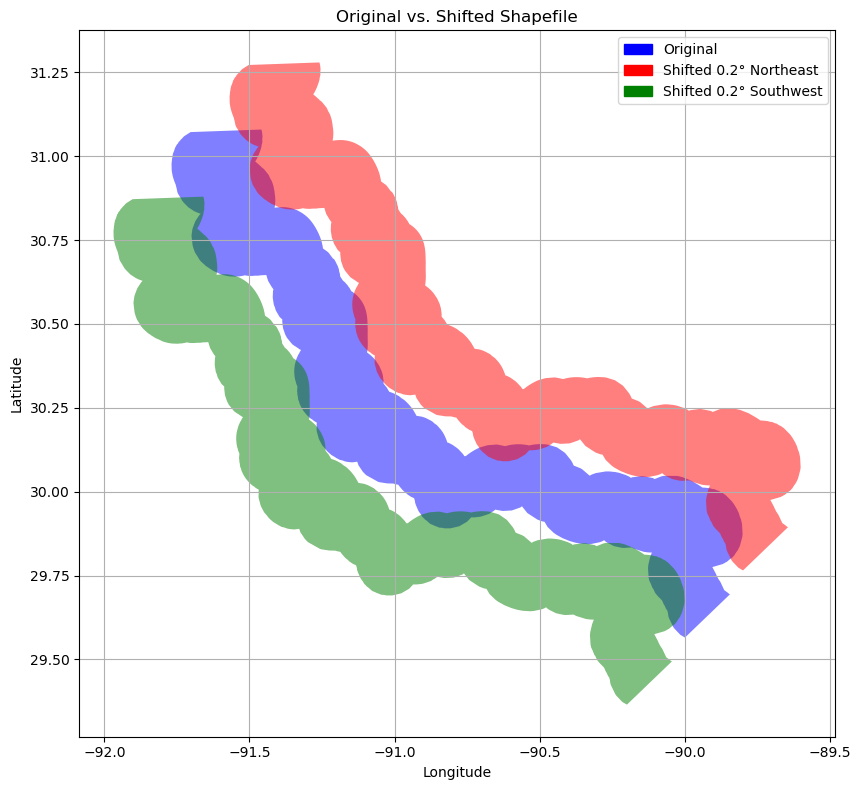

In [69]:
# Move 0.1° east (positive x direction = longitude)
ca_north = ca_shapefile.copy()
ca_north['geometry'] = ca_north['geometry'].translate(xoff=0.2, yoff=0.2)
ca_south = ca_shapefile.copy()
ca_south['geometry'] = ca_south['geometry'].translate(xoff=-0.2, yoff=-0.2)

import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 8))

ca_shapefile.plot(ax=ax, color='blue', alpha=0.5)
ca_north.plot(ax=ax, color='red', alpha=0.5)
ca_south.plot(ax=ax, color='green', alpha=0.5)

# Create legend handles manually
original_patch = mpatches.Patch(color='blue', label='Original')
north_patch = mpatches.Patch(color='red', label='Shifted 0.2° Northeast')
south_patch = mpatches.Patch(color='green', label='Shifted 0.2° Southwest')

ax.legend(handles=[original_patch, north_patch, south_patch])

ax.set_title('Original vs. Shifted Shapefile')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)
plt.tight_layout()
plt.show()


In [82]:
tempo_2024_08 =  xr.open_dataset("../../data/tempo_data/no2_monthly_files/tempo_no2_2025-01.nc", engine='netcdf4')
tempo_2024_08 = tempo_2024_08[['vertical_column_troposphere']]
tempo_2024_08 = tempo_2024_08.rio.write_crs("EPSG:4326")  # assuming your data is in WGS84

tempo_2024_08_ca = tempo_2024_08.rio.clip(ca_shapefile.geometry, shapefile.crs, drop=True)
tempo_2024_08_ca_north = tempo_2024_08.rio.clip(ca_north.geometry, shapefile.crs, drop=True)
tempo_2024_08_ca_south = tempo_2024_08.rio.clip(ca_south.geometry, shapefile.crs, drop=True)

tempo_2024_08_ca_df = tempo_2024_08_ca.mean(dim=['latitude','longitude'], keep_attrs=True)
tempo_2024_08_ca_df = tempo_2024_08_ca_df[['vertical_column_troposphere']].to_dataframe().reset_index()
tempo_2024_08_ca_df = tempo_2024_08_ca_df.drop(columns='spatial_ref')
tempo_2024_08_ca_df.rename(columns={'vertical_column_troposphere':'cancer_alley'}, inplace=True)

tempo_2024_08_ca_north_df = tempo_2024_08_ca_north.mean(dim=['latitude','longitude'], keep_attrs=True)
tempo_2024_08_ca_north_df = tempo_2024_08_ca_north_df[['vertical_column_troposphere']].to_dataframe().reset_index()
tempo_2024_08_ca_north_df = tempo_2024_08_ca_north_df.drop(columns='spatial_ref')
tempo_2024_08_ca_north_df.rename(columns={'vertical_column_troposphere':'northeast'}, inplace=True)

tempo_2024_08_ca_south_df = tempo_2024_08_ca_south.mean(dim=['latitude','longitude'], keep_attrs=True)
tempo_2024_08_ca_south_df = tempo_2024_08_ca_south_df[['vertical_column_troposphere']].to_dataframe().reset_index()
tempo_2024_08_ca_south_df = tempo_2024_08_ca_south_df.drop(columns='spatial_ref')
tempo_2024_08_ca_south_df.rename(columns={'vertical_column_troposphere':'southwest'}, inplace=True)

southwest_winds = pd.merge(tempo_2024_08_ca_df, tempo_2024_08_ca_north_df, on='time')
southwest_winds = pd.merge(southwest_winds, tempo_2024_08_ca_south_df, on='time')
southwest_winds.mean()

,time,cancer_alley,northeast,southwest
0,2025-01-01 07:00:00,3.714304,2.243233,3.746089
1,2025-01-01 08:00:00,3.657537,2.061183,3.762847
2,2025-01-01 09:00:00,3.481092,2.155611,3.571308
3,2025-01-01 10:00:00,2.797052,1.775941,3.222050
4,2025-01-01 11:00:00,2.417633,1.572951,2.544363
...,...,...,...,...
273,2025-01-31 13:00:00,2.757833,3.328509,2.000894
274,2025-01-31 14:00:00,2.982815,3.224641,2.249927
275,2025-01-31 15:00:00,3.424694,3.044383,2.419207
276,2025-01-31 16:00:00,2.407531,2.022934,1.539460


In [54]:
tempo_2025_03 =  xr.open_dataset("../../data/tempo_data/no2_monthly_files/tempo_no2_2025-03.nc", engine='netcdf4')
tempo_2025_03 = tempo_2025_03[['vertical_column_troposphere']]
tempo_2025_03 = tempo_2025_03.rio.write_crs("EPSG:4326")  # assuming your data is in WGS84

tempo_2025_03_ca = tempo_2025_03.rio.clip(ca_shapefile.geometry, shapefile.crs, drop=True)
tempo_2025_03_ca_north = tempo_2025_03.rio.clip(ca_north.geometry, shapefile.crs, drop=True)
tempo_2025_03_ca_south = tempo_2025_03.rio.clip(ca_south.geometry, shapefile.crs, drop=True)

tempo_2025_03_ca_df = tempo_2025_03_ca.mean(dim=['latitude','longitude'], keep_attrs=True)
tempo_2025_03_ca_df = tempo_2025_03_ca_df[['vertical_column_troposphere']].to_dataframe().reset_index()
tempo_2025_03_ca_df = tempo_2025_03_ca_df.drop(columns='spatial_ref')
tempo_2025_03_ca_df.rename(columns={'vertical_column_troposphere':'cancer_alley'}, inplace=True)

tempo_2025_03_ca_north_df = tempo_2025_03_ca_north.mean(dim=['latitude','longitude'], keep_attrs=True)
tempo_2025_03_ca_north_df = tempo_2025_03_ca_north_df[['vertical_column_troposphere']].to_dataframe().reset_index()
tempo_2025_03_ca_north_df = tempo_2025_03_ca_north_df.drop(columns='spatial_ref')
tempo_2025_03_ca_north_df.rename(columns={'vertical_column_troposphere':'northeast'}, inplace=True)

tempo_2025_03_ca_south_df = tempo_2025_03_ca_south.mean(dim=['latitude','longitude'], keep_attrs=True)
tempo_2025_03_ca_south_df = tempo_2025_03_ca_south_df[['vertical_column_troposphere']].to_dataframe().reset_index()
tempo_2025_03_ca_south_df = tempo_2025_03_ca_south_df.drop(columns='spatial_ref')
tempo_2025_03_ca_south_df.rename(columns={'vertical_column_troposphere':'southwest'}, inplace=True)

northeast_winds = pd.merge(tempo_2025_03_ca_df, tempo_2025_03_ca_north_df, on='time')
northeast_winds = pd.merge(northeast_winds, tempo_2025_03_ca_south_df, on='time')

,time,cancer_alley,northeast,southwest
0,2025-03-01 09:00:00,4.464439,3.104211,3.226881
1,2025-03-01 10:00:00,4.031537,2.436563,3.196243
2,2025-03-01 11:00:00,3.639688,2.234128,2.981697
3,2025-03-01 12:00:00,2.943969,1.826838,2.823383
4,2025-03-01 13:00:00,2.685110,1.803602,2.188824
...,...,...,...,...
324,2025-03-31 14:00:00,1.410891,1.556621,0.855352
325,2025-03-31 15:00:00,1.713906,1.748698,1.055889
326,2025-03-31 16:00:00,2.276054,2.285370,1.176476
327,2025-03-31 17:00:00,2.454902,2.413489,1.037169


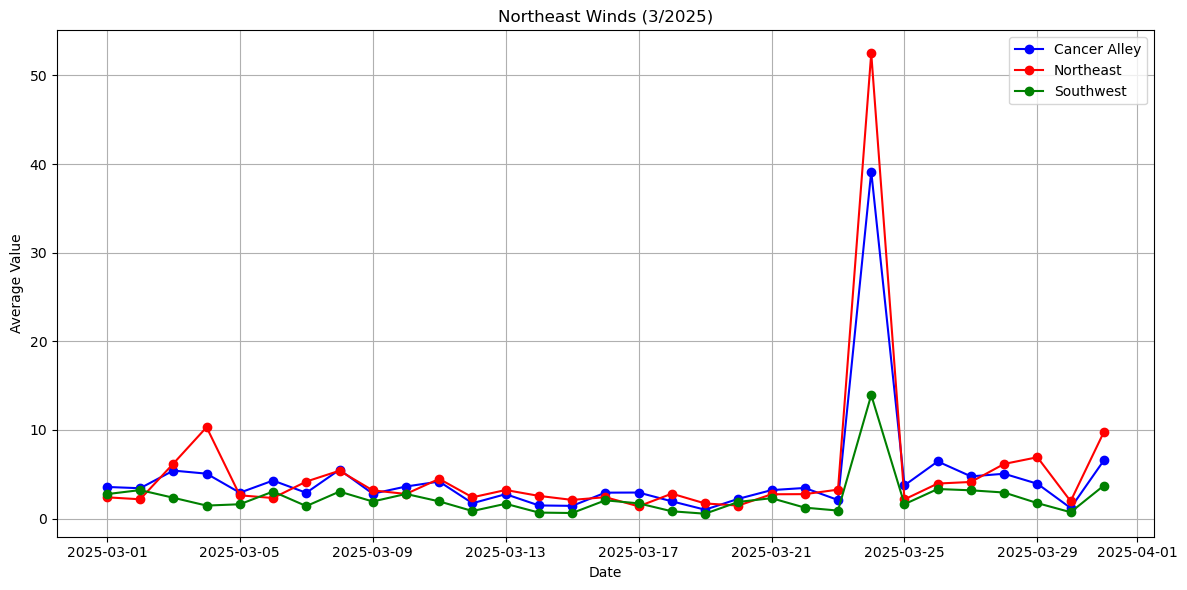

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'time' is datetime
northeast_winds['time'] = pd.to_datetime(northeast_winds['time'])

# Group by day and take mean
daily_means = northeast_winds.groupby(northeast_winds['time'].dt.date).agg({
    'cancer_alley': 'mean',
    'northeast': 'mean',
    'southwest':'mean'
}).reset_index()
# daily_means.rename(columns={'time': 'date'}, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_means['time'], daily_means['cancer_alley'], marker='o', label='Cancer Alley', color='blue')
plt.plot(daily_means['time'], daily_means['northeast'], marker='o', label='Northeast', color='red')
plt.plot(daily_means['time'], daily_means['southwest'], marker='o', label='Southwest', color='green')

plt.xlabel('Date')
plt.ylabel('Average Value')
plt.title('Northeast Winds (3/2025)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
southwest_wind_months = ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05']

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'time' is datetime
northeast_winds['time'] = pd.to_datetime(northeast_winds['time'])

# Group by day and take mean
daily_means = northeast_winds.groupby(northeast_winds['time'].dt.date).agg({
    'cancer_alley': 'mean',
    'northeast': 'mean',
    'southwest':'mean'
}).reset_index()
# daily_means.rename(columns={'time': 'date'}, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_means['time'], daily_means['cancer_alley'], marker='o', label='Cancer Alley', color='blue')
plt.plot(daily_means['time'], daily_means['northeast'], marker='o', label='Northeast', color='red')
plt.plot(daily_means['time'], daily_means['southwest'], marker='o', label='Southwest', color='green')

plt.xlabel('Date')
plt.ylabel('Average Value')
plt.title('Northeast Winds (3/2025)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
southwest_winds

,time,cancer_alley,northeast,southwest
0,2024-08-01 07:00:00,3.813286,4.343474,2.451375
1,2024-08-01 08:00:00,3.444643,3.781349,2.083304
2,2024-08-01 09:00:00,3.753959,3.026123,2.120461
3,2024-08-01 10:00:00,3.409192,2.289597,1.878863
4,2024-08-01 11:00:00,3.954605,2.699549,2.222882
...,...,...,...,...
172,2024-08-31 09:00:00,2.674440,2.697888,2.126064
173,2024-08-31 10:00:00,2.858824,2.736839,1.842907
174,2024-08-31 16:00:00,2.865429,2.032147,1.510702
175,2024-08-31 17:00:00,3.773527,3.194792,1.890936


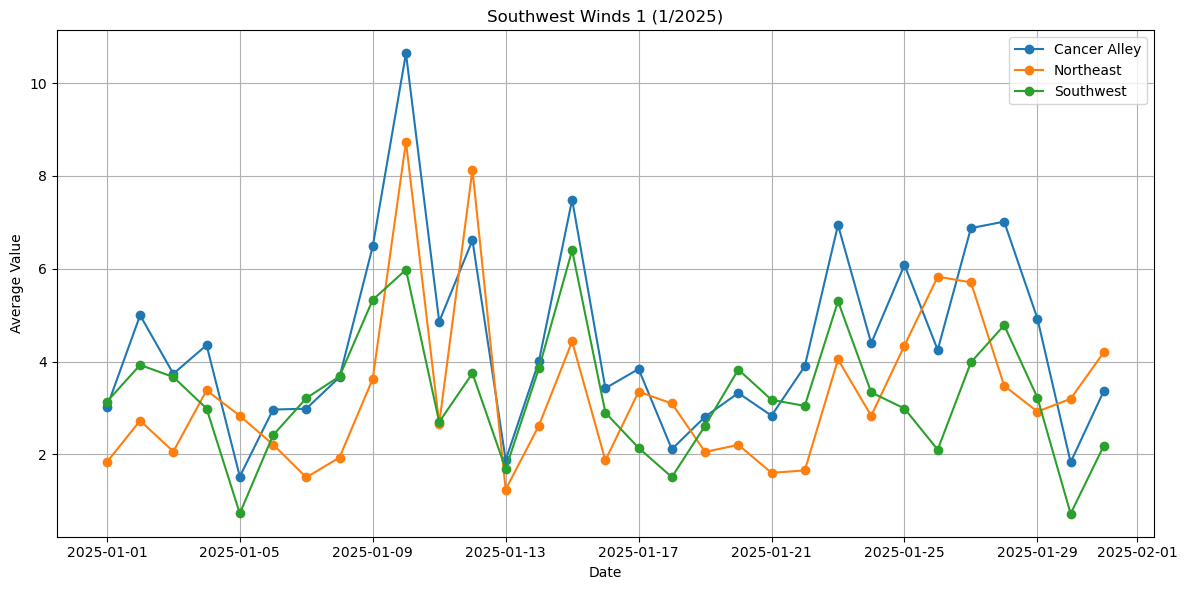

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'time' is datetime
southwest_winds['time'] = pd.to_datetime(southwest_winds['time'])

# Group by day and take mean
daily_means = southwest_winds.groupby(southwest_winds['time'].dt.date).agg({
    'cancer_alley': 'mean',
    'northeast': 'mean',
    'southwest':'mean'
}).reset_index()
# daily_means.rename(columns={'time': 'date'}, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_means['time'], daily_means['cancer_alley'], marker='o', label='Cancer Alley')
plt.plot(daily_means['time'], daily_means['northeast'], marker='o', label='Northeast')
plt.plot(daily_means['time'], daily_means['southwest'], marker='o', label='Southwest')

plt.xlabel('Date')
plt.ylabel('Average Value')
plt.title('Southwest Winds 1 (1/2025)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
southwest_winds.mean()

time            2025-01-16 11:59:47.050359552
cancer_alley                         4.465399
northeast                            3.338326
southwest                            3.294503
dtype: object

In [86]:
northeast_winds.mean()

time            2025-03-16 05:36:06.565349632
cancer_alley                         4.574512
northeast                            5.235384
southwest                            2.329236
dtype: object